#  Echo and reberveration

In this iPython notebook we will solve an exercise taken from the Proakis-Manolakis book about reberveration and echo [1]:
![](img/echoCancellation3.png)
![](img/echoCancellation4.png)

## Exercise (a)

To get the impulse response of exercise (a) we need to apply the inverse Z transform to the provided transfer function:

$$
y[n] = x[n] - \alpha y[n-D].
$$

Defining a support of 50 points, and setting the parameters $\alpha=0.7$ and $D=5$, we get the following impulse response:

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re', 'solve']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<StemContainer object of 3 artists>

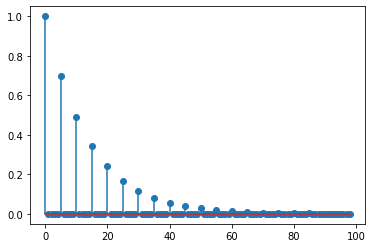

In [19]:
%pylab inline
import numpy as np

def comb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = x[n] - alpha*(0 if n-D<0 else y[n-D])
    return y
        
kronecker = np.zeros(99)
kronecker[0] = 1
    
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), use_line_collection=True)

We observe that, in effect, the impulse response of the comb filter is a function that decays exponentially, as we would expect from an echoe: the repetitions get softer each time, not louder. We can process a recording and hear the added effect:

In [5]:
from scipy.io import wavfile
from IPython.display import Audio

fs_wav, x_wav = wavfile.read('./wav/highquality_100520.wav')
distance = 100 # m
y = comb(x_wav, alpha=0.5, D=int((distance/380)*fs_wav))
Audio(y, rate=fs_wav) 

Indeed, it sounds like an echoe, which indicates that the comb filter is suitable for this task.

## Exercise (b)

The new provided transfer function defines the following difference equation:

$$
y[n] = -\alpha x[n] + x[n-D] + \alpha y[n-D],
$$

and reusing parameters $\alpha$ and $D$, it would look like this:

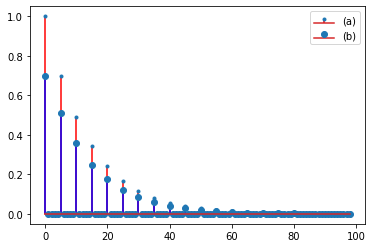

In [7]:
def allpasscomb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = -alpha*x[n] + (0 if n-D<0 else x[n-D]) + alpha*(0 if n-D<0 else y[n-D])
    return y
        
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='(a)')
pylab.stem(np.abs(allpasscomb(kronecker,alpha=0.7,D=5)), linefmt='blue', use_line_collection=True, label='(b)')
pylab.legend()

The figure shows that it has an identical impulse response than the one of exercise (a), however, the function is shifter to the left in one unit. Now, if we put multiple all pass filters in cascade and setup the parameters as in unit 1, the impulse response would look like this:

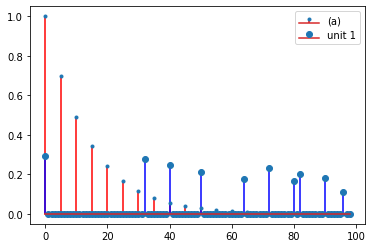

In [8]:
def cascade(x, alphas, Ds):
    y = x
    for i in range(0,len(alphas)):
        y = allpasscomb(y,alphas[i],Ds[i])
    return y

pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='(a)')
pylab.stem(np.abs(cascade(kronecker, [0.7,0.665,0.63175], [50,40,32])), linefmt='blue', use_line_collection=True, label='unit 1')
pylab.legend()

The exponential decay shape has been lost. How will it be heard?

In [9]:
y = cascade(x_wav, [0.7,0.665,0.63175], np.multiply(100, [50,40,32])) # escalamos los retrasos para escucharlos
Audio(y, rate=fs_wav) 

It's completely a mess of repetitions, and in some seconds, the audio becomes incomprehensible. Now let's use the parameters from unit 2:

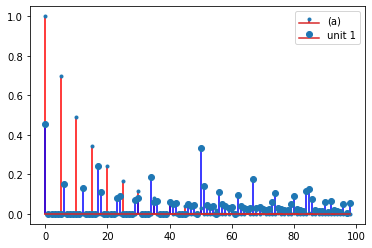

In [10]:
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='(a)')
pylab.stem(np.abs(cascade(kronecker, [0.7,0.77,0.847], [50,17,6])), linefmt='blue', use_line_collection=True, label='unit 1')
pylab.legend()

Again, we are curious to know how it will sound.

In [12]:
y = cascade(x_wav, [0.7,0.77,0.847], np.multiply(100, [50,17,6])) # escalamos los retrasos para escucharlos
Audio(y, rate=fs_wav) 

Despite the fact that the audio does not have the same quality than exercise (a), the audio is clear enough almost to the end.

## Exercise (c)

At this point, we can answer the question in exercise (c). Unit 1 is a better reverberator because it doesn't produce clear repetitions of the signal. And this might be happening because in the impulse response of unit 1, the amplitude of the delays does not decrease as $g_k>g_{k+1}>0$.

In [13]:
print(np.divide([0.7,0.665,0.63175],[0.665,0.63175,1])) # unit 1
print(np.divide([0.7,0.77,0.847], [0.77,0.847,1])) # unit 2

[1.05263158 1.05263158 0.63175   ]
[0.90909091 0.90909091 0.847     ]


## Exercise (d)

TBD...

## Exercise (e)

Let's start by calculating the phase of the cascade filter of unit 1, for this we take multiply each transfer function with a 1 ($z^D/z^D$):

$$
H(z) = \frac{(1-0.7 z^{50})}{(z^{50}-0.7)}\frac{(1-0.66 z^{40})}{(z^{40}-0.66)}\frac{(1-0.63175 z^{32})}{(z^{32}-0.63175)},
$$

and use the `scipy.signal.freqz_zpk` function to specify the zeros, poles, and gain:

    ⎛                                                                         
    ⎜                                                                         
atan⎜─────────────────────────────────────────────────────────────────────────
    ⎜                122                       120      2                     
    ⎝- 0.294079625⋅re   (z) + 2170.601712125⋅re   (z)⋅im (z) - 2583016.0374287

                           121                           119      3           
           - 35.87771425⋅re   (z)⋅im(z) + 86824.068485⋅re   (z)⋅im (z) - 60959
──────────────────────────────────────────────────────────────────────────────
    118      4                         116      6                         114 
5⋅re   (z)⋅im (z) + 1188703980.42471⋅re   (z)⋅im (z) - 283166269622.601⋅re   (

              117      5                         115      7                   
178.4833185⋅re   (z)⋅im (z) + 19698523104.1809⋅re   (z)⋅im (z) - 3586772748552
──────────────────────────────────────────────────

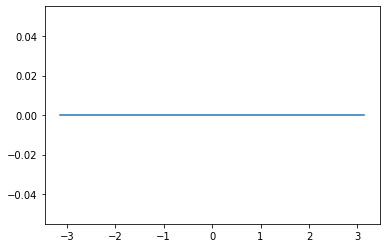

In [34]:
import scipy.signal
from sympy import pprint, Symbol, expand, simplify, solve, Poly, re, im, atan, lambdify
import numpy as np

z = Symbol('z')
Hnum = (1-0.7*z**50)*(1-0.665*z**40)*(1-0.63175*z**32)
Hden = (z**50-0.7)*(z**40-0.665)*(z**32-0.63175)

phase = atan(im(Hnum)/re(Hnum)) - atan(im(Hden)/re(Hden))
#pprint(phase)

N = 100
x = np.linspace(-np.pi,np.pi,N)
y = np.zeros(N)
f = lambdify(z,phase)
for n in range(0,N):
    y[n] = f(x[n])

    
pylab.plot(x,y)

#pprint(expand(Hd))

#num = list(Poly(Hnum).all_coeffs())
#den = list(Poly(Hden).all_coeffs())

#signal.TransferFunction(num, den)
#print(signal)

#w, h = scipy.signal.freqz(np.flip(b),np.flip(a))
#ylab.plot(w, np.angle(h)) # we don't want to have discontinuities around the -pi to pi interval

## References

1. J. Proakis, D. Manolakis. Digital Signal Processing: Principles, Algorithms and Applications, 3rd Edition. Peason.
2. http://eeweb.poly.edu/iselesni/EL6113/matlab_examples/frequency_response_demo/html/frequency_response_demo.html
3. http://www.ee.ic.ac.uk/pcheung/teaching/ee2_signals/Lecture%208%20-%20Frequency%20Response.pdf